In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

df=pd.read_csv('labels_only.csv') # use the files and run the code

#load the saved model weights
checkpoint = "bert-base-uncased"
tokenizer  = AutoTokenizer.from_pretrained(checkpoint)

model  = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=4
)


# alter the path to model weights as per presence
with open("model_weights.pkl", "rb") as f:
    state_dict = pickle.load(f)
model.load_state_dict(state_dict)
model.to(device)


Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# !pip install transformers -U

^C
Note: you may need to restart the kernel to use updated packages.


In [12]:
#tokenization and to get embeddings function
def tokenize_fn(examples):
    return tokenizer(
        str(examples["text"]),
        truncation=True,
        padding="max_length",
        max_length=512
    )


def get_cls_embeddings(texts):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.bert(**inputs, output_hidden_states=True)
    cls_embeddings = outputs.hidden_states[-1][:,0,:]  # CLS token
    return cls_embeddings.cpu().numpy()


def plt_sne(df):
  sample_texts = df['text'][:100] #input text or use a text variable
  embeddings = get_cls_embeddings(sample_texts.tolist())

  # Assume `embeddings` shape is [num_samples, embedding_dim]
  # And `df['labels']` contains the class labels

  # 1. Reduce dimensionality using t-SNE
  tsne = TSNE(n_components=2, random_state=42)
  reduced = tsne.fit_transform(embeddings)

  # 2. Encode labels to integers for coloring
  labels = df['labels'][:len(reduced)]
  label_codes = labels.astype('category').cat.codes
  unique_labels = labels.astype('category').cat.categories

  # 3. Plot with proper coloring and legend
  plt.figure(figsize=(10, 7))
  scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=label_codes, cmap='tab10', alpha=0.7)

  # 4. Create a custom legend
  handles = []
  for i, label in enumerate(unique_labels):
      handles.append(plt.Line2D([], [], marker='o', color='w', markerfacecolor=plt.cm.tab10(i/10), label=label, markersize=10))
  plt.legend(handles=handles, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

  plt.title("Sentence Embedding Clusters from BERT")
  plt.xlabel("t-SNE Component 1")
  plt.ylabel("t-SNE Component 2")
  plt.tight_layout()
  plt.show()


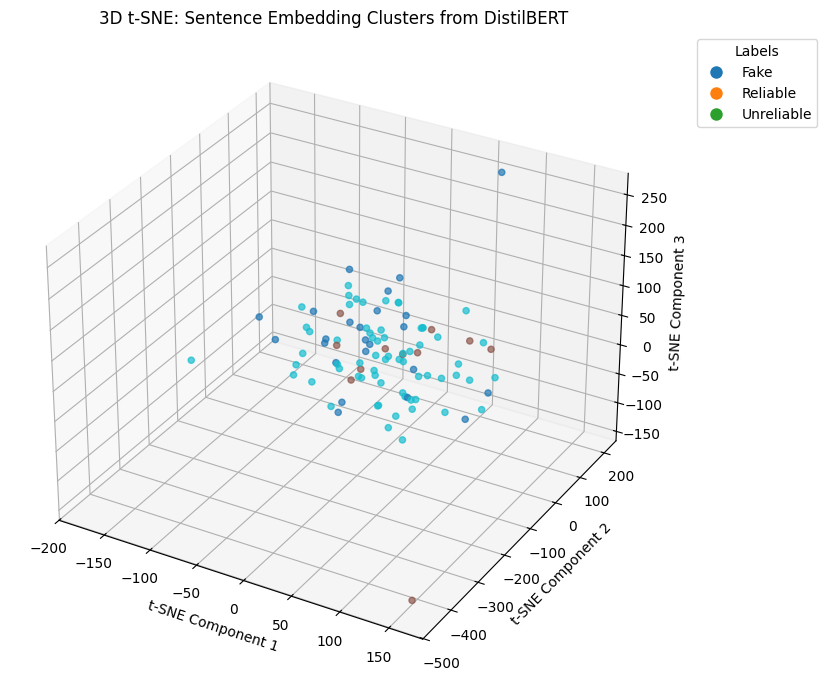

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D  # <-- Required for 3D plots

sample_texts = df['text'][:100] #input text or use a text variable
embeddings = get_cls_embeddings(sample_texts.tolist())

# 1. Reduce dimensionality using 3D t-SNE
tsne = TSNE(n_components=3, random_state=42,perplexity=0.5)
reduced = tsne.fit_transform(embeddings)

# 2. Encode labels for coloring
labels = df['labels'][:len(reduced)]
label_codes = labels.astype('category').cat.codes
unique_labels = labels.astype('category').cat.categories

# 3. 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced[:, 0], reduced[:, 1], reduced[:, 2],
                    c=label_codes, cmap='tab10', alpha=0.7)

# 4. Custom legend
handles = []
for i, label in enumerate(unique_labels):
    handles.append(plt.Line2D([], [], marker='o', color='w',
                              markerfacecolor=plt.cm.tab10(i/10), label=label, markersize=10))
ax.legend(handles=handles, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

# 5. Labels and title
ax.set_title("3D t-SNE: Sentence Embedding Clusters from DistilBERT")
ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")
ax.set_zlabel("t-SNE Component 3")
plt.tight_layout()
plt.show()


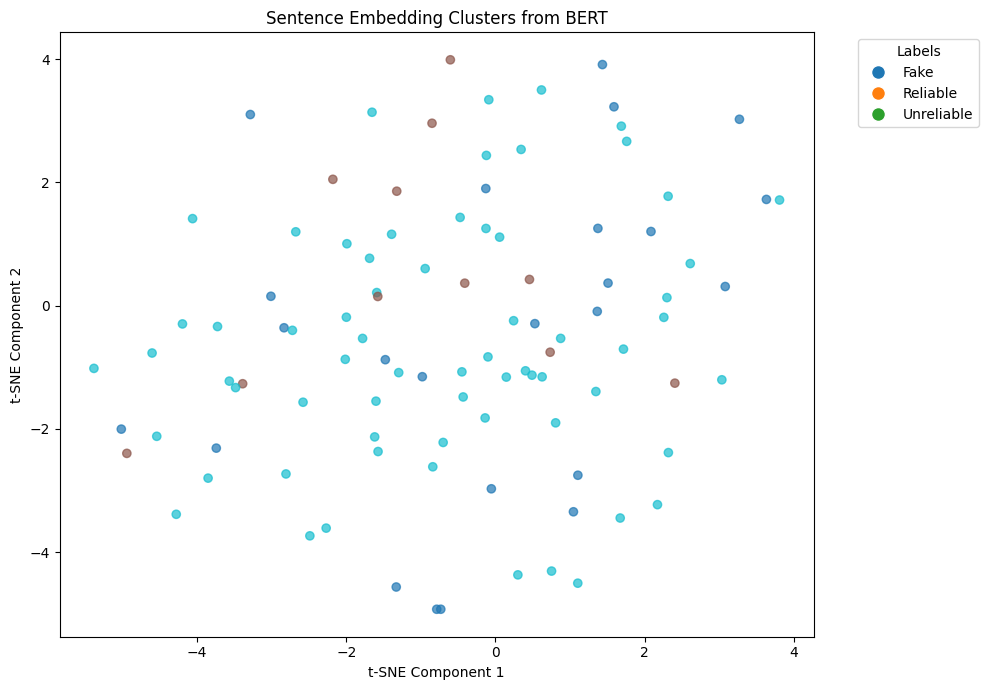

In [13]:
plt_sne(df)

# SHAP: To understand which tokens shape the model's decision, by identifying positive and negative contributors.

In [16]:
from transformers import pipeline
import shap


def plt_shap(df):
  # 1. Create a pipeline with return_all_scores=True for SHAP compatibility
  pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

  # 2. Wrap the pipeline with a SHAP explainer
  explainer = shap.Explainer(pipe)

  # 3. Get and truncate the input text
  text = df['text'][0][:510]
  # text="The government asked people to refrain from taking vaccines"

  # Tokenize the input to ensure truncation matches model expectations
  tokens = tokenizer.tokenize(text)

  # Leave space for [CLS] and [SEP]
  max_tokens = 510
  truncated_tokens = tokens[:max_tokens]

  # Convert back to a string
  truncated_text = tokenizer.convert_tokens_to_string(truncated_tokens)

  # 4. Explain the prediction on the sample
  shap_values = explainer([truncated_text])

  # 5. Plot SHAP values over tokens
  shap.plots.text(shap_values[0])

In [17]:
# plt_sne(df)
plt_shap(df)

Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [04:07, 247.12s/it]              
